# Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [290]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pylab as plt
import xgboost
from lightgbm import LGBMClassifier
import shap
shap.initjs()
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("data_banknote_authentication.csv", sep = ';',encoding='cp1251')
print(df.shape)
df.head(3)

(1372, 5)


,Дисперсия изображения,асимметрия изображения,эксцесс изображения,энтропия изображения,класс
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


Набор данных для аутентификации банкнот. Содержит 4 признака, длина датасета 1372. Данные были извлечены из изображений, снятых с подлинных и поддельных образцов, похожих на банкноты. Для оцифровки использовалась промышленная камера, обычно используемая для проверки печати. Окончательные изображения имеют размер 400x400 пикселей. За счет объектива и расстояния до исследуемого объекта были получены полутоновые изображения с разрешением около 660 dpi. Инструмент Wavelet Transform использовался для извлечения признаков из изображений.

Посмотрим на соотношение классов:

In [291]:
df.iloc[:, -1].value_counts()

0    762
1    610
Name: класс, dtype: int64

Визуализируем данные в зависимости от признаков.

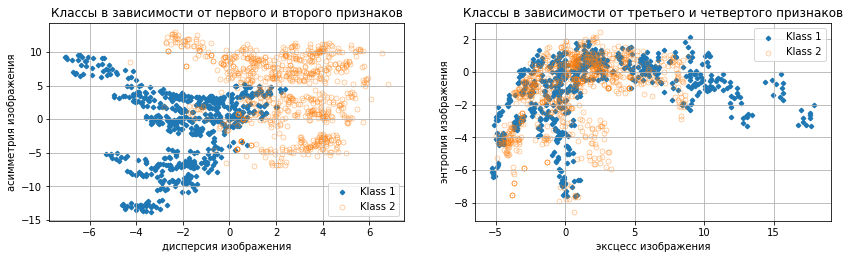

In [292]:
plt.figure(figsize=(14, 8))
plt.subplot(2,2,1)
plt.scatter(df.iloc[:, 0].where(df.iloc[:, 4]==1), df.iloc[:, 1].where(df.iloc[:, 4]==1), marker="x", linewidth=4, s=8, alpha=1, label='Klass 1');
plt.scatter(df.iloc[:, 0].where(df.iloc[:, 4]==0), df.iloc[:, 1].where(df.iloc[:, 4]==0),marker='.', linewidth=5, s=2, alpha=0.5, label='Klass 2');

plt.title('Классы в зависимости от первого и второго признаков')
plt.xlabel("дисперсия изображения")
plt.ylabel("асимметрия изображения")
plt.grid()
plt.legend()

plt.subplot(2,2,2)
plt.scatter(df.iloc[:, 2].where(df.iloc[:, 4]==1), df.iloc[:, 3].where(df.iloc[:, 4]==1), marker="x", linewidth=4, s=8, alpha=1, label='Klass 1');
plt.scatter(df.iloc[:, 2].where(df.iloc[:, 4]==0), df.iloc[:, 3].where(df.iloc[:, 4]==0),marker='.', linewidth=5, s=2, alpha=0.5, label='Klass 2');

plt.title('Классы в зависимости от третьего и четвертого признаков')
plt.xlabel("эксцесс изображения")
plt.ylabel("энтропия изображения")
plt.grid()
plt.legend()

In [293]:
features = ['Дисперсия изображения', 'асимметрия изображения', 'эксцесс изображения','энтропия изображения']

In [294]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['класс'], random_state=0)

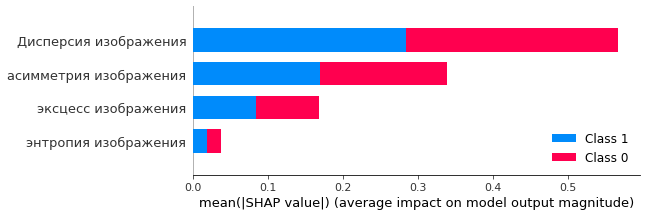

In [295]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
# объясните предсказания модели с помощью SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])
shap.summary_plot(shap_values,X_test)

Диаграмма показывает влиятельность признаков на принятие решения моделью. Наиболее сильно влияет признак "дисперсия изображения", меньше всего признак "энтпропия изображения".

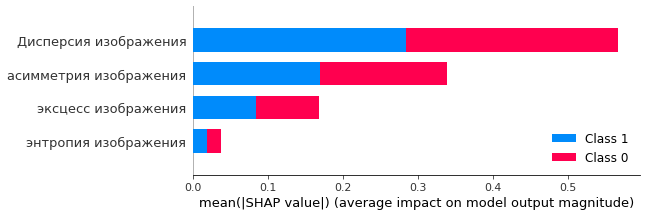

In [296]:
#для топ 10%
shap.summary_plot(shap_values[:10],X_test[:10])

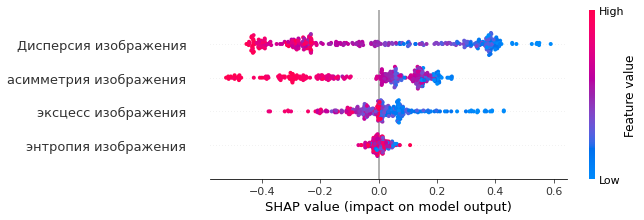

In [297]:
if isinstance(shap_values,list):
    shap_values = shap_values[1]
shap.summary_plot(shap_values,X_test)

Высокие значения "дисперсии изображения", "ассиметрии изображения" и "эксцесса изображения"  уменьшают вероятность того, что банктота поддельная. Низкие значения "энтропии изображения" увеличивают вероятность того, что банкнота поддельная. Первые три признака более важные чем, 4-тый.

In [298]:
idx = 18
shap.force_plot(explainer.expected_value[1], shap_values[idx,:], X_train.iloc[idx,:])

Диаграмма показывает что было с вектором Шепли в каждом конкретном случае, показывает почему скор в для этого примера равен нулю. Самый главный признак, оказавший макимальное влияние на скор дисперсия изображения, который понижает вероятность того, что купюра поддельная, повышает вероятность признак "симметрия изображения".

In [299]:
idx = 29
shap.force_plot(explainer.expected_value[1], shap_values[idx,:], X_train.iloc[idx,:])

В этом примере главный признак, оказавший макимальное влияние на скор "ассиметрия изображения", который понижает вероятность того, что купюра поддельная, чуть-менее значимый признак "дисперсия изображения", повышает вероятность признак "экцесс изображения".

In [300]:
idx = 150
shap.force_plot(explainer.expected_value[1], shap_values[idx,:], X_train.iloc[idx,:])

В этом примере главный признак, оказавший макимальное влияние на скор "ассиметрия изображения", который понижает вероятность того, что купюра поддельная, повышает вероятность признак "экцесс изображения". Значение скора 0.04.

In [301]:
idx = 188
shap.force_plot(explainer.expected_value[1], shap_values[idx,:], X_train.iloc[idx,:])

В этом примере главный признак, оказавший максимальное влияние на скор "дисперсия изображения", который повышает вероятность того, что купюра поддельная. Второй по значимости признак "асимметрия изображения" Значение скора 1.

In [302]:
idx = 300
shap.force_plot(explainer.expected_value[1], shap_values[idx,:], X_train.iloc[idx,:])

В этом примере главные признаки, оказавшие максимальное влияние на скор "ассиметрия изображения" и "дисперсия изображения", которые понижают вероятность того, что купюра поддельная. Признак "эксцесс изображения" значение скора повышает. Значение скора 0.0.